In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from collections import Counter

# Data

This data is actually related to the elastic strain engineering task: given the (modified) deformation tensor, predict, whether the tiny diamond crystal under this deformation is a direct-bandgap semiconductor, or not.

I will save you some time and process the data for you.

In [2]:
df = pd.read_csv('c_gw_direct.csv')

In [3]:
df.shape

(9766, 7)

In [4]:
df

,exx,exy,exz,eyz,eyy,ezz,is_direct
0,-0.049931,0.019480,-0.012549,0.071484,0.000141,0.036242,False
1,0.057604,0.070671,-0.010140,-0.063918,0.032494,-0.078462,False
2,-0.020174,-0.059848,0.017878,0.077713,-0.087613,-0.079651,False
3,-0.023523,-0.026120,0.045459,-0.035286,-0.000705,0.038353,False
4,-0.050925,-0.006037,-0.042681,-0.016254,-0.019372,-0.037559,False
...,...,...,...,...,...,...,...
9761,-0.096821,0.049679,-0.065829,0.060488,0.008918,0.006889,False
9762,-0.074071,0.027148,-0.056629,-0.068732,0.070384,-0.008722,False
9763,-0.061505,0.015496,0.077352,-0.037589,-0.047513,-0.045182,False
9764,-0.037760,0.037480,0.002881,-0.059958,-0.047096,0.060803,False


In [5]:
df.is_direct.sum()

1376

In [6]:
# Getting arrays from table
X = df[['exx', 'exy', 'exz', 'eyz', 'eyy', 'ezz']].values
y = df['is_direct'].ravel()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=124)
Counter(y_train)

Counter({False: 6723, True: 1089})

# (3 pts) Train and evaluate a simple neural network classifier

- Train a model
- Calculate its precision, recall, f1-score
- Take a look at the confusion matrix

### Train a model

In [47]:
model = MLPClassifier(max_iter=10000)
model.fit(X_train, y_train)

MLPClassifier(max_iter=10000)

### Look at the metrics

In [48]:
predictions = model.predict(X_test)

precision = precision_score(y_test, predictions)
print(f'Precision: {precision}')

recall = recall_score(y_test, predictions)
print(f'Recall: {recall}')

f1 = f1_score(y_test, predictions)
print(f'f1-score: {f1}')

Precision: 0.7883817427385892
Recall: 0.662020905923345
f1-score: 0.7196969696969697


### Print the confusion matrix

In [10]:
confusion_matrix(y_test, predictions)

array([[1623,   44],
       [ 137,  150]])

## Итоги
- Recall 0.66 показывает, что модель в среднем обнаруживает класс в 66% случаев. Это лишь немного лучше, чем 50% угадывание.
- f1-score будем использовать как некую метрику, характеризующую баланс между precision и recall. Здесь за счет неплохой точности (precision) предсказания в целом f1-score повышается.
- Нужно искать метод для повышения precision и recall.

# (3 pts) Use an undersampling technique to balance classes
- Balance training sample
- Train new model with the same hyperparameters as before
- Evaluate its metrics. Is is better than the original model?

In [49]:
idx_for_larger_class = np.nonzero(y_train == False)[0]
idx_for_smaller_class = np.nonzero(y_train == True)[0]

less_idx_for_larger_class = np.random.choice(idx_for_larger_class,
                                            len(idx_for_smaller_class),
                                            replace=False)

new_idx = list(less_idx_for_larger_class) + list(idx_for_smaller_class)

X_train_new = X_train[new_idx, :]
y_train_new = y_train[new_idx]

model_balanced = MLPClassifier(max_iter=10000)
model_balanced.fit(X_train_new, y_train_new)


MLPClassifier(max_iter=10000)

In [50]:
predictions_balanced = model_balanced.predict(X_test)

precision = precision_score(y_test, predictions_balanced)
print(f'Precision: {precision}')

recall = recall_score(y_test, predictions_balanced)
print(f'Recall: {recall}')

f1 = f1_score(y_test, predictions_balanced)
print(f'f1-score: {f1}')

Precision: 0.5155642023346303
Recall: 0.9233449477351916
f1-score: 0.66167290886392


In [51]:
confusion_matrix(y_test, predictions_balanced)

array([[1418,  249],
       [  22,  265]])

## Итоги
- За счет большей сбалансированности данных модель стала лучше отличать один класс от другого. Об этом свидетельствует увеличение значения recall.
- Точность предсказания при этом уменьшилась. Это можно связать с уменьшением выборки, что в целом негативно влияет на обобщаемость модели.
- f1-score уменьшился на 0.05, поэтому вердикт следующий: случайная балансировка на данной выборке показывает плохие результаты.

# (3 pts) Try the imblearn package and its undersampling methods
https://imbalanced-learn.org/stable/under_sampling.html
- Try NearMiss, NeighbourhoodCleaningRule, and EditedNearestNeighbours methods
- Do they perform better than the random undersampling?

### You may need to reinstall sklearn if it is old

In [52]:
# !pip uninstall -v scikit-learn -y

In [53]:
# !pip install -v scikit-learn

In [54]:
# !pip install imblearn

In [55]:
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, NeighbourhoodCleaningRule

### Balancing with NearMiss

In [56]:
nm1 = NearMiss(version=1)
X_resampled_nm1, y_resampled_nm1 = nm1.fit_resample(X_train, y_train)

In [57]:
model_balanced_nearmiss = MLPClassifier(max_iter=10000)
model_balanced_nearmiss.fit(X_resampled_nm1, y_resampled_nm1)

MLPClassifier(max_iter=10000)

In [58]:
predictions_balanced_nearmiss = model_balanced_nearmiss.predict(X_test)

precision = precision_score(y_test, predictions_balanced_nearmiss)
print(f'Precision: {precision}')

recall = recall_score(y_test, predictions_balanced_nearmiss)
print(f'Recall: {recall}')

f1 = f1_score(y_test, predictions_balanced_nearmiss)
print(f'f1-score: {f1}')

Precision: 0.534521158129176
Recall: 0.8362369337979094
f1-score: 0.6521739130434783


### Balancing with NeighbourhoodCleaningRule

In [59]:
ncr = NeighbourhoodCleaningRule()
X_resampled_ncr, y_resampled_ncr = ncr.fit_resample(X_train, y_train)

In [60]:
model_balanced_ncr = MLPClassifier(max_iter=10000)
model_balanced_ncr.fit(X_resampled_ncr, y_resampled_ncr)

MLPClassifier(max_iter=10000)

In [61]:
predictions_balanced_ncr = model_balanced_ncr.predict(X_test)

precision = precision_score(y_test, predictions_balanced_ncr)
print(f'Precision: {precision}')

recall = recall_score(y_test, predictions_balanced_ncr)
print(f'Recall: {recall}')

f1 = f1_score(y_test, predictions_balanced_ncr)
print(f'f1-score: {f1}')

Precision: 0.6755852842809364
Recall: 0.7038327526132404
f1-score: 0.6894197952218429


### Balancing with EditedNearestNeighbours

In [62]:
enn = EditedNearestNeighbours()
X_resampled_enn, y_resampled_enn = enn.fit_resample(X_train, y_train)

In [63]:
model_balanced_enn = MLPClassifier(max_iter=10000)
model_balanced_enn.fit(X_resampled_enn, y_resampled_enn)

MLPClassifier(max_iter=10000)

In [64]:
predictions_balanced_enn = model_balanced_enn.predict(X_test)

precision = precision_score(y_test, predictions_balanced_enn)
print(f'Precision: {precision}')

recall = recall_score(y_test, predictions_balanced_enn)
print(f'Recall: {recall}')

f1 = f1_score(y_test, predictions_balanced_enn)
print(f'f1-score: {f1}')

Precision: 0.25
Recall: 0.010452961672473868
f1-score: 0.020066889632107024


## Итоги
- NearMiss и NeighbourhoodCleaningRule дают результат хуже, чем без балансировки. Применение этих методов дает свои результаты, но в итоге f1-score не увеличивается, поэтому их использование здесь не оправданно.
- EdintedNearestNeighbours показывает колоссально негативный результат, метрики говорят сами за себя. Не рекомендую здесь.

# (3 pts) Perform hyperparameter tuning
- Run a cycle through some hyperparater settings in order to find the best ones
- E.g. hidden layer sizes, alpha regularization ...
- You need to be able to outperform your initial model
- I do not care whether you use balanced or imbalanced training set

In [65]:
hidden_layer_sizes_list = [
    (200, ),
    (100, ),
    (100, 100, ),
    (50, 50, ),
    (50, 50, 50, ),
    (50, 50, 50, 50),
]

alpha_list = [
    0.000001, 0.00001, 0.0001, 0.001, 0.01,
]

In [66]:
metrics_grid = {
    'hidden_layer_sizes': [],
    'alpha': [],
    'precision': [],
    'recall': [],
    'f1': [],
}

for hidden_layer_sizes_ in hidden_layer_sizes_list:
    for alpha_ in alpha_list:
        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes_, alpha=alpha_, max_iter=10000)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)

        metrics_grid['hidden_layer_sizes'].append(hidden_layer_sizes_)
        metrics_grid['alpha'].append(alpha_)
        metrics_grid['precision'].append(precision)
        metrics_grid['recall'].append(recall)
        metrics_grid['f1'].append(f1)


/home/ilyavoronov/miniconda3/envs/plasma_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ilyavoronov/miniconda3/envs/plasma_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ilyavoronov/miniconda3/envs/plasma_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
metrics_grid_df = pd.DataFrame.from_dict(metrics_grid)
metrics_grid_df

,hidden_layer_sizes,alpha,precision,recall,f1
0,"(200,)",0.000001,0.851301,0.797909,0.823741
1,"(200,)",0.000010,0.806897,0.815331,0.811092
2,"(200,)",0.000100,0.890688,0.766551,0.823970
3,"(200,)",0.001000,0.862745,0.766551,0.811808
4,"(200,)",0.010000,0.714286,0.261324,0.382653
5,"(100,)",0.000001,0.832579,0.641115,0.724409
6,"(100,)",0.000010,0.741784,0.550523,0.632000
7,"(100,)",0.000100,0.757991,0.578397,0.656126
8,"(100,)",0.001000,0.816832,0.574913,0.674847
9,"(100,)",0.010000,0.000000,0.000000,0.000000


In [68]:
pivot = metrics_grid_df.pivot_table(
    index=['hidden_layer_sizes'],
    columns=['alpha'],
    values='f1')

<AxesSubplot:xlabel='alpha', ylabel='hidden_layer_sizes'>

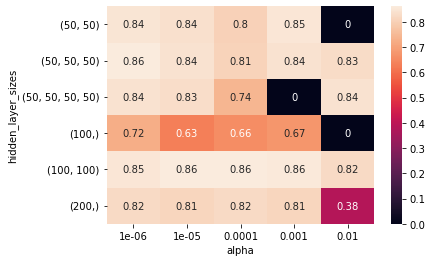

In [69]:
sns.heatmap(pivot, annot=True)

## Итоги
- По сводной таблице видно, что с уменьшением alpha и увеличением числа слоев растет f1-score. Далее уже при повышении числа нейронов в слое тоже идет повышение. Но в то же время это ведет к увеличению расчетного времени. 
- Лучше всего показали себя модели с размером (50, 50, 50) и (100, 100). Но последней для достижения этого уровня потребовался меньший параметр регуляризации.
- Оптимальной предлагается считать модель со слеудющими гипер-параметрами:

In [72]:
metrics_grid_df.loc[12]

hidden_layer_sizes    (100, 100)
alpha                     0.0001
precision                   0.88
recall                  0.843206
f1                       0.86121
Name: 12, dtype: object

# My final mark is $\min(mark, 10)$